<a href="https://colab.research.google.com/github/HuyenNguyenHelen/LING-5412/blob/main/Midterm_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries that will be used 
import numpy as np
import tarfile
import glob
import re
import pandas as pd
#from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading the data

In [2]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2021-10-12 04:22:00--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz.3’

review_polarity.tar 100%[===================>]   2.98M  5.62MB/s    in 0.5s    

2021-10-12 04:22:01 (5.62 MB/s) - ‘review_polarity.tar.gz.3’ saved [3127238/3127238]



In [3]:
# Untar the dataset
my_tar = tarfile.open('/content/review_polarity.tar.gz')
my_tar.extractall('/content/') 
my_tar.close()


In [4]:
# Exploring the data sizes

paths_pos = glob.glob('/content/txt_sentoken/pos/*.txt')
paths_neg = glob.glob('/content/txt_sentoken/neg/*.txt')
pos_neg_paths = paths_pos + paths_neg

n_pos = len(paths_pos)
n_neg = len(paths_neg)

print('the number of positive instances: {} \nthe number of negative instances: {}'.format(n_pos, n_neg))

the number of positive instances: 1000 
the number of negative instances: 1000


In [5]:
# Reformating the dataset into csv for convenience 

def to_df (folder):
  data_dic = {}
  data_dic['doc'], data_dic['label'] = [], []
  for file in folder:
    fo = open(file)
    doc = fo.read()
    data_dic['doc'].append(doc)
    if 'pos' in file:
      data_dic['label'].append(1)
    elif 'neg' in file:
      data_dic['label'].append(-1)
    else:
      print('error', file)
  df = pd.DataFrame.from_dict(data_dic)
  return df
    
data = to_df(pos_neg_paths)

data.head()

,doc,label
0,star wars : episode i - the phantom menace rev...,1
1,'contact' shows why jodie foster is one of our...,1
2,""" the deep end "" uses a color palette of rich...",1
3,"steven spielberg's "" amistad , "" which is base...",1
4,"corey yuen's latest film , "" hero "" is notable...",1


# Data pre-processing

In [6]:
# Data preprocessing

from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
stemmer = nltk.stem.porter.PorterStemmer()
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def tokenizer (doc):
  return re.split("\W+", doc)   # return a list of tokens without punctuations

def stopword_remover (bow):
  filtered_bow = [w for w in bow if not w.lower() in stopwords]
  return filtered_bow

def top_freq_w (freq_dic, top_n, stopword_removing = ''):
  sorted_dic = {k:v for k, v in sorted(freq_dic.items(), key = lambda item: item[1], reverse=True)}
  if stopword_removing is False:
    return {k:v for k, v in list(sorted_dic.items())[:top_n]}
  elif stopword_removing is True:
    filtered_dic = {k: v for k, v in sorted_dic.items() if k not in stopwords}
    return {k:v for k, v in list(filtered_dic.items())[:top_n]}
  

def preprocessor (text):
  ## removing punctuations and characters
  text = re.sub(r'[^\w\s]', '', text)
  ## stripping
  text = ' '.join([w.strip() for w in text.split()])
  ## lowcasing
  text = text.lower()
  ## removing stopword
  text = stopword_remover (text.split())
  ##stemmming
  text = [stemmer.stem(w) for w in text]
  ## lematization
  text = [lemmatizer.lemmatize(w) for w in text]
  return ' '.join([w for w in text])

data['doc'] = data['doc'].apply(lambda x:  preprocessor (x) )
data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,doc,label
0,star war episod phantom menac review review ja...,1
1,contact show jodi foster one best actress see ...,1
2,deep end use color palett rich earth tone surr...,1
3,steven spielberg amistad base true stori group...,1
4,corey yuen latest film hero notabl two front f...,1
...,...,...
1995,im give stinker normal worst would ever rate m...,-1
1996,movi kill emilio estevez first fifteen minut s...,-1
1997,alexand duma three musket one oftenadapt liter...,-1
1998,steve martin one funniest men aliv take true s...,-1


# Feature Representation
As requested, we are going to extract 10000 words from the training set for representing the documents

In [7]:
# Spliting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split (data['doc'], data['label'] , train_size = 0.8, random_state = 42, shuffle = True, stratify=data['label'])
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (1600,) (1600,)
Shapes of X_test, y_test:  (400,) (400,)


In [8]:
# we will use 10000 most frequent word from training, excluding stopwords
## Getting terms and their frequency 
word_freq = {}
for doc in X_train.to_list():
  for token in tokenizer (doc):
    word_freq[token] = word_freq.get(token,0)+1

## Getting 10000 terms with highest frequency, excluding stopwords
vocabulary = top_freq_w(word_freq, 10000, stopword_removing = True)


In [9]:
# Binary representing documents based on occurrance of features in documents
def doc_representor (doc):
  doc_vec = []
  token_list = tokenizer (doc)
  for feature in vocabulary.keys():
    if feature in token_list:
      doc_vec.append(1)
    else:
       doc_vec.append(0)
  return doc_vec

X_train = X_train.apply(lambda x: doc_representor(x))
X_test = X_test.apply(lambda x: doc_representor(x))


In [10]:
# Visualize the data after representing
print('feature representation of documents in TRAINING set')
X_train = X_train.apply(pd.Series)
X_train.columns = vocabulary.keys()
print(X_train.shape)
X_train

feature representation of documents in TRAINING set
(1600, 10000)


,film,movi,one,like,charact,get,make,time,scene,even,good,stori,play,see,would,much,also,way,go,seem,end,take,look,two,come,first,well,work,thing,realli,perform,plot,year,littl,know,life,peopl,could,never,love,...,87,butter,introductori,grenad,bythebook,snapshot,clubber,cashier,stung,rife,hectic,taho,matern,nova,mcgehe,siegel,evoc,truest,adulteri,repercuss,lehmann,propens,resurfac,goddess,refriger,scorn,unrelentingli,vivica,onearm,semest,boorish,evapor,fong,tobi,bustl,wallop,scheider,windshield,snowfal,premonit
478,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
488,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1499,0,1,1,1,1,1,1,0,0,1,0,1,1,0,1,1,0,0,1,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1605,1,1,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
511,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0,1,1,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,1,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1452,1,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,1,0,1,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
248,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
303,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [11]:
# Visualize the data after representing
print('feature representation of documents in TEST set')
X_test = X_test.apply(pd.Series)
X_test.columns = vocabulary.keys()
print(X_test.shape)
X_test

feature representation of documents in TEST set
(400, 10000)


,film,movi,one,like,charact,get,make,time,scene,even,good,stori,play,see,would,much,also,way,go,seem,end,take,look,two,come,first,well,work,thing,realli,perform,plot,year,littl,know,life,peopl,could,never,love,...,87,butter,introductori,grenad,bythebook,snapshot,clubber,cashier,stung,rife,hectic,taho,matern,nova,mcgehe,siegel,evoc,truest,adulteri,repercuss,lehmann,propens,resurfac,goddess,refriger,scorn,unrelentingli,vivica,onearm,semest,boorish,evapor,fong,tobi,bustl,wallop,scheider,windshield,snowfal,premonit
1748,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1020,1,1,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88,1,0,1,1,1,0,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,0,0,0,1,1,1,1,1,0,1,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1466,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1491,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,1,0,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1821,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1099,1,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1654,1,1,1,0,1,1,1,1,0,0,1,0,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
X_train.values

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

# Building Perceptron Models

In [13]:
# Defining functions

## Defining the Vanilla perceptron model function
def vanila_perceptron (X, Y, weight, bias):
  idx = np.random.permutation(X.index)
  X = X.reindex(idx).reset_index(drop = True)
  Y = Y.reindex(idx).reset_index(drop = True) 
  tr_loss = 0
  for x, y in zip(X.values,Y):
    a = np.dot(weight, x) + bias
    ya = np.dot(y, a)
    if ya <=0:
      weight += np.dot(x, y)
      bias +=  y
    tr_loss += np.max([0, ya*(-1)])
  avg_loss = tr_loss/X.shape[0]
  return weight, bias, avg_loss 

## Defining the Averaged perceptron model function
def avg_perceptron (X, Y, weight, bias, u, beta, c):
  idx = np.random.permutation(X.index)
  X = X.reindex(idx).reset_index(drop = True) 
  Y = Y.reindex(idx).reset_index(drop = True) 
  tr_loss = 0
  for x, y in zip(X.values,Y):
    a = np.dot(weight, x) + bias
    ya = np.dot(y, a)
    if ya <=0:
      weight += np.dot(x, y)
      bias +=  y
      u += np.dot (y, c, x)
      beta += np.dot (y, c)
    else:
      pass
    c+=1
    tr_loss += np.max([0, ya*(-1)])
  avg_loss = tr_loss/X.shape[0]
  avg_weight = weight - (u/c)
  avg_bias = bias - (beta/c)
  return avg_weight, avg_bias, avg_loss

## Defining a prediction function
def predict (X, Y, weight, bias):
  a = np.dot(weight, X.values.T) + bias
  y_class = [1 if y_pred > 0 else -1 for y_pred in a]
  ya = [np.dot(y_true, y_pred) for y_true, y_pred in zip (Y, a)]
  loss = np.sum([np.max([0, i*(-1)]) for i in ya])/X.shape[0]                
  return y_class, loss

## Defining a function to print model's performance 
def printing_eval_scores (y_true, y_pred, report=''):
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  precision = sklearn.metrics.precision_score(y_true, y_pred)
  recall = sklearn.metrics.recall_score(y_true, y_pred)
  f1 = sklearn.metrics.f1_score(y_true, y_pred)
  print('accuracy score: {:.3f}'.format(accuracy))
  print('precision score: {:.3f}'.format(precision))
  print('recall score: {:.3f}'.format(recall))
  print('F1 score: {:.3f}'.format(f1))
  if report is True:
    print(classification_report(y_true, y_pred))
  else:
    pass
  return accuracy, precision, recall, f1


In [14]:
# Training the vanilla model
print('..............Training the Vanilla Perceptron .........................................')
n_iter = 10
weight = np.zeros(X_train.shape[1])
bias = 0
all_tr_loss = []
all_test_loss = []
F1_tr = []
F1_test = []
for iter in range(n_iter):
  print('\n====================iteration %s=======================' % str(iter+1))
  weight, bias, tr_loss = vanila_perceptron (X_train, y_train, weight, bias)
  y_predict, test_loss = predict(X_test, y_test, weight, bias)
  all_tr_loss.append(tr_loss)
  all_test_loss.append (test_loss)
  ## on training set
  print('Model performance on training set:')
  print ('average loss in training: ', tr_loss )
  _, _,_, f1 = printing_eval_scores (y_train, predict(X_train, y_train, weight, bias)[0], report = False)
  F1_tr.append (f1)
  ## on test set
  print('\nModel performance on test set:')
  print ('average loss in testing: ', test_loss )
  _, _,_, f1 = printing_eval_scores (y_test, y_predict, report = True)
  F1_test.append (f1)

max_f1 = max(F1_test)
idx_max_f1 = F1_test.index(max(F1_test))
print('Best performance is in iteration {}: F1 = {:.3f}, loss = {:.3f}'.format(idx_max_f1 +1, max_f1, all_test_loss[idx_max_f1]))


..............Training the Vanilla Perceptron .........................................

====================iteration 1=======================
Model performance on training set:
average loss in training:  9.936875
accuracy score: 0.894
precision score: 0.840
recall score: 0.973
F1 score: 0.902

Model performance on test set:
average loss in testing:  10.8575
accuracy score: 0.770
precision score: 0.708
recall score: 0.920
F1 score: 0.800
              precision    recall  f1-score   support

          -1       0.89      0.62      0.73       200
           1       0.71      0.92      0.80       200

    accuracy                           0.77       400
   macro avg       0.80      0.77      0.76       400
weighted avg       0.80      0.77      0.76       400


====================iteration 2=======================
Model performance on training set:
average loss in training:  3.380625
accuracy score: 0.956
precision score: 0.989
recall score: 0.921
F1 score: 0.954

Model performance on 

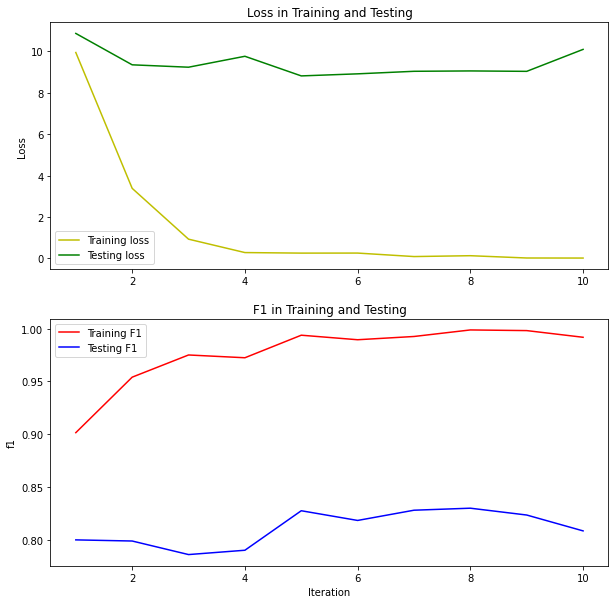

In [15]:
# Visualizing the loss and F1 in traning and testing over iterations
fig, (axs1, axs2) = plt.subplots(2, figsize=(10,10)) 
axs1.plot([i for i in np.arange(1, n_iter+1, 1)], all_tr_loss, 'y', label='Training loss')
axs1.plot([i for i in  np.arange(1, n_iter+1, 1)], all_test_loss, 'g', label='Testing loss')
axs1.set_title('Loss in Training and Testing')
axs1.set_ylabel('Loss')
axs1.legend()

axs2.plot([i for i in  np.arange(1, n_iter+1, 1)], F1_tr, 'r', label='Training F1')
axs2.plot([i for i in  np.arange(1, n_iter+1, 1)], F1_test, 'b', label='Testing F1')
axs2.set_title('F1 in Training and Testing')
axs2.set_xlabel('Iteration')
axs2.set_ylabel('f1')
axs2.legend()

fig.show()

In [16]:
# Training the Averaged perceptron model

print('..............Training Averaged Perceptron .........................................')
n_iter = 10
weight, bias = np.zeros(X_train.shape[1]), 0
u, beta =  np.zeros(X_train.shape[1]), 0
c = 1
all_tr_avg_loss = []
all_test_avg_loss = []
F1_tr = []
F1_test = []
for iter in range(n_iter):
  print('\n====================iteration %s=======================' % str(iter+1))
  weight, bias, avg_tr_loss = avg_perceptron (X_train, y_train, weight, bias, u, beta, c)
  y_predict, test_loss = predict(X_test, y_test, weight, bias)
  all_tr_avg_loss.append(avg_tr_loss)
  all_test_avg_loss.append (test_loss)
  ## on training set
  print('Model performance on training set:')
  print ('average loss in training: ', avg_tr_loss )
  _, _,_, f1 = printing_eval_scores (y_train, predict(X_train, y_train, weight, bias)[0], report = False)
  F1_tr.append (f1)
  ## on test set
  print('\nModel performance on test set:')
  print ('average loss in testing: ', test_loss )
  _, _,_, f1 = printing_eval_scores (y_test, y_predict, report = True)
  F1_test.append (f1)

max_f1 = max(F1_test)
idx_max_f1 = F1_test.index(max(F1_test))
print('Best performance is in iteration {}: F1 = {:.3f}, loss = {:.3f}'.format(idx_max_f1 +1, max_f1, all_test_avg_loss[idx_max_f1]))

..............Training Averaged Perceptron .........................................

====================iteration 1=======================
Model performance on training set:
average loss in training:  10.6625
accuracy score: 0.589
precision score: 0.993
recall score: 0.180
F1 score: 0.305

Model performance on test set:
average loss in testing:  62.19664896939411
accuracy score: 0.560
precision score: 1.000
recall score: 0.120
F1 score: 0.214
              precision    recall  f1-score   support

          -1       0.53      1.00      0.69       200
           1       1.00      0.12      0.21       200

    accuracy                           0.56       400
   macro avg       0.77      0.56      0.45       400
weighted avg       0.77      0.56      0.45       400


====================iteration 2=======================
Model performance on training set:
average loss in training:  3.3672267332916928
accuracy score: 0.547
precision score: 0.525
recall score: 1.000
F1 score: 0.688

Model

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model performance on training set:
average loss in training:  4.129000234228607
accuracy score: 0.504
precision score: 1.000
recall score: 0.007
F1 score: 0.015

Model performance on test set:
average loss in testing:  149.85690193629
accuracy score: 0.505
precision score: 1.000
recall score: 0.010
F1 score: 0.020
              precision    recall  f1-score   support

          -1       0.50      1.00      0.67       200
           1       1.00      0.01      0.02       200

    accuracy                           0.51       400
   macro avg       0.75      0.51      0.34       400
weighted avg       0.75      0.51      0.34       400


====================iteration 5=======================
Model performance on training set:
average loss in training:  1.0574309025609003
accuracy score: 0.602
precision score: 1.000
recall score: 0.204
F1 score: 0.339

Model performance on test set:
average loss in testing:  75.90623360399768
accuracy score: 0.573
precision score: 0.968
recall score: 0.15

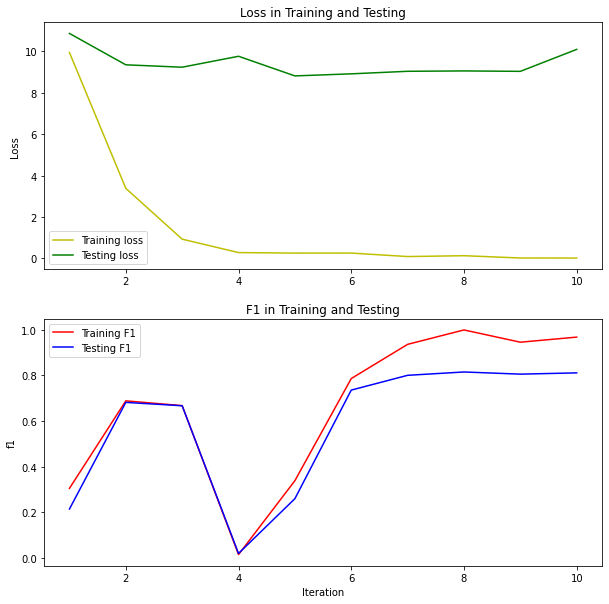

In [17]:
# Visualizing the loss and F1 in traning and testing over iterations
fig, (axs1, axs2) = plt.subplots(2, figsize=(10,10)) 
axs1.plot([i for i in  np.arange(1, n_iter+1, 1)], all_tr_loss, 'y', label='Training loss')
axs1.plot([i for i in  np.arange(1, n_iter+1, 1)], all_test_loss, 'g', label='Testing loss')
axs1.set_title('Loss in Training and Testing')
axs1.set_ylabel('Loss')
axs1.legend()

axs2.plot([i for i in  np.arange(1, n_iter+1, 1)], F1_tr, 'r', label='Training F1')
axs2.plot([i for i in  np.arange(1, n_iter+1, 1)], F1_test, 'b', label='Testing F1')
axs2.set_title('F1 in Training and Testing')
axs2.set_xlabel('Iteration')
axs2.set_ylabel('f1')
axs2.legend()

fig.show()